In [14]:
!pip install optuna catboost lightgbm xgboost

In [15]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

warnings.filterwarnings("ignore")
SEED = 42
TARGET_COL = 'LoanApproved'

# Загрузка данных
train_df = pd.read_csv("train_c.csv")
test_df = pd.read_csv("test_c.csv") if os.path.exists("test_c.csv") else None

# Обработка пропусков в таргете и кодирование
train_df = train_df.dropna(subset=[TARGET_COL])

if train_df[TARGET_COL].dtype == 'object':
    le = LabelEncoder()
    train_df[TARGET_COL] = le.fit_transform(train_df[TARGET_COL])
else:
    train_df[TARGET_COL] = train_df[TARGET_COL].astype(int)

print(f"Данные загружены. Размер: {train_df.shape}")

Данные загружены. Размер: (10487, 35)


проводим EDA

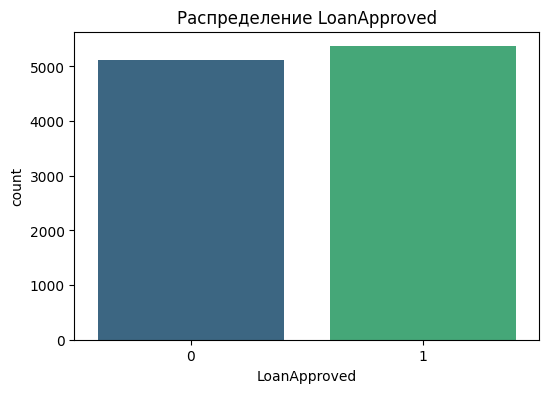

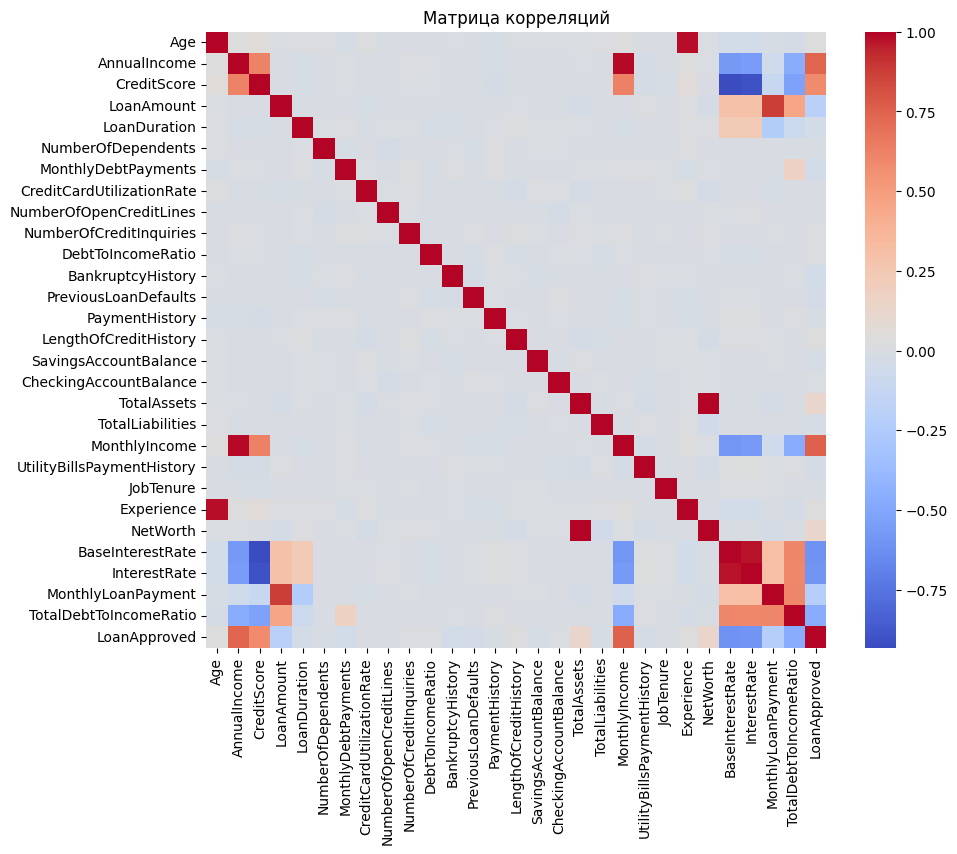

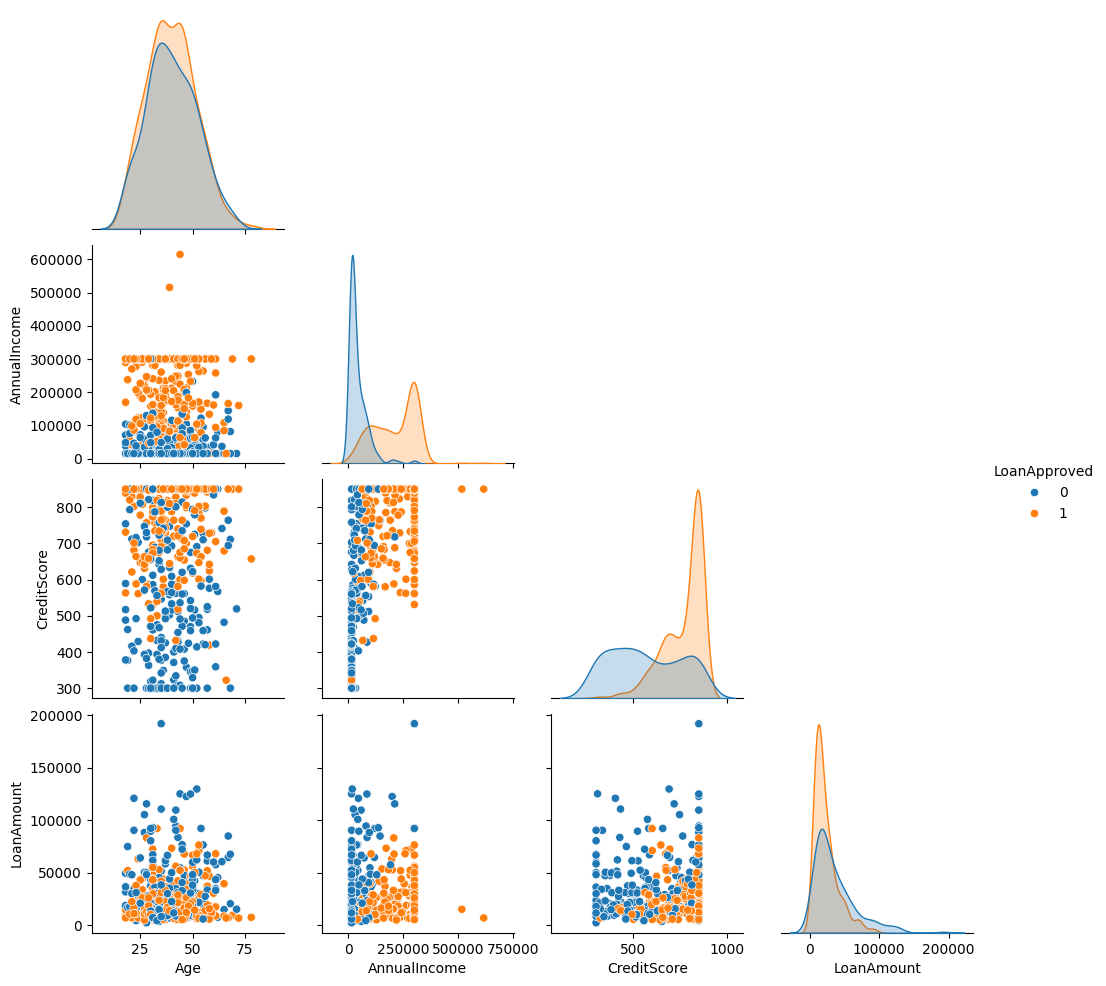

In [16]:
# График целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df[TARGET_COL], palette='viridis')
plt.title(f'Распределение {TARGET_COL}')
plt.show()

# Корреляционная матрица (только числовые)
num_cols = train_df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Матрица корреляций')
plt.show()

# Pairplot для нескольких признаков
sample_cols = list(train_df.select_dtypes(include=[np.number]).columns[:4]) + [TARGET_COL]
sns.pairplot(train_df[sample_cols].sample(min(500, len(train_df))), hue=TARGET_COL, corner=True)
plt.show()

Визуальный анализ показал, что наиболее разделимая способность наблюдается у признака CreditScore. Признаки дохода и суммы кредита имеют логарифмическое распределение с тяжелыми хвостами, что требует предварительной обработки. Четкой линейной зависимости между возрастом и одобрением кредита не наблюдается.

In [17]:
def cleanup_data(df: pd.DataFrame):
    df = df.copy()

    if "ApplicationDate" in df:
        dt = pd.to_datetime(df["ApplicationDate"], errors="coerce")
        df["App_Year"] = dt.dt.year.fillna(0)

    eps = 1e-6
    if "MonthlyLoanPayment" in df and "MonthlyIncome" in df:
        df["PayToInc"] = df["MonthlyLoanPayment"] / (df["MonthlyIncome"] + eps)
    if "LoanAmount" in df and "AnnualIncome" in df:
        df["LoanToInc"] = df["LoanAmount"] / (df["AnnualIncome"] + eps)

    # Логарифмирование
    log_cols = ["MonthlyIncome", "LoanAmount", "TotalAssets", "TotalLiabilities", "AnnualIncome"]
    for c in log_cols:
        if c in df:
            # safe log
            mn = df[c].min()
            add = abs(mn) + 1 if mn < 0 else 1
            df[c] = np.log1p(df[c] + add)

    return df

train_clean = cleanup_data(train_df)
test_clean = cleanup_data(test_df) if test_df is not None else None

# Разделение признаков
X = train_clean.drop(columns=[TARGET_COL, "ID", "ApplicationDate", "RiskScore"], errors='ignore')
y = train_clean[TARGET_COL]

# Определение типов колонок
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

# Пайплайн обработки
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

# Трансформируем данные сразу, чтобы подавать в модели готовые массивы
X_prep = preprocessor.fit_transform(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_prep, y, test_size=0.2, random_state=SEED, stratify=y)

print(f"Размерность данных после обработки: {X_train.shape}")

Размерность данных после обработки: (8389, 53)


Реализуем класс бэггинга

In [18]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.models = []
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            indices = rng.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[indices], y.iloc[indices]

            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self

    def predict_proba(self, X):
        # Усредняем вероятности всех моделей
        probs = np.mean([clf.predict_proba(X) for clf in self.models], axis=0)
        return probs

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Сравнение
bag_custom = CustomBaggingClassifier(n_estimators=10, random_state=SEED)
bag_custom.fit(X_train, y_train)
p_custom = bag_custom.predict_proba(X_val)[:, 1]

bag_sklearn = RandomForestClassifier(n_estimators=10, random_state=SEED) # RF - это по сути бэггинг деревьев
bag_sklearn.fit(X_train, y_train)
p_sklearn = bag_sklearn.predict_proba(X_val)[:, 1]

print(f"Custom Bagging ROC-AUC: {roc_auc_score(y_val, p_custom):.4f}")
print(f"Sklearn RF ROC-AUC:     {roc_auc_score(y_val, p_sklearn):.4f}")

Custom Bagging ROC-AUC: 0.9698
Sklearn RF ROC-AUC:     0.9698


Реализуем Градиентный бустинг

In [19]:
class CustomGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_pred = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        pos_frac = np.mean(y)
        self.initial_pred = np.log(pos_frac / (1 - pos_frac))

        y_pred = np.full(y.shape, self.initial_pred)

        for _ in range(self.n_estimators):
            probs = self._sigmoid(y_pred)
            residuals = y - probs


            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=SEED)
            tree.fit(X, residuals)

            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.models.append(tree)

        return self

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], self.initial_pred)
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)

        probs_1 = self._sigmoid(y_pred)
        return np.column_stack((1 - probs_1, probs_1))

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Сравнение
gb_custom = CustomGradientBoosting(n_estimators=50, learning_rate=0.1)
gb_custom.fit(X_train, y_train)
p_gb_custom = gb_custom.predict_proba(X_val)[:, 1]

print(f"Custom Boosting ROC-AUC: {roc_auc_score(y_val, p_gb_custom):.4f}")

Custom Boosting ROC-AUC: 0.9747


сравниваем разные модели в градиентном бустинге

In [20]:
models = {
    "Sklearn GB": GradientBoostingClassifier(random_state=SEED),
    "LightGBM": lgb.LGBMClassifier(random_state=SEED, verbose=-1),
    "XGBoost": xgb.XGBClassifier(random_state=SEED, eval_metric='logloss'),
    "CatBoost": cb.CatBoostClassifier(random_state=SEED, verbose=0)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    p_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, p_pred)
    results[name] = score
    print(f"{name} ROC-AUC: {score:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nЛучшая модель: {best_model_name}")

Sklearn GB ROC-AUC: 0.9809
LightGBM ROC-AUC: 0.9813
XGBoost ROC-AUC: 0.9825
CatBoost ROC-AUC: 0.9833

Лучшая модель: CatBoost


с помощью optuna подбираем параметры

In [21]:
def objective(trial):
    # Подбираем параметры для LightGBM (как пример быстрой модели)
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
    }

    model = lgb.LGBMClassifier(**params, random_state=SEED)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=False)

print("Лучшие параметры:", study.best_params)
best_params = study.best_params

[I 2025-12-09 22:37:10,602] A new study created in memory with name: no-name-a1cfd55e-97eb-4a91-a40a-d459f13a8a53
[I 2025-12-09 22:37:11,365] Trial 0 finished with value: 0.9819863317621044 and parameters: {'n_estimators': 274, 'learning_rate': 0.09931820278859747, 'num_leaves': 25, 'max_depth': 4, 'lambda_l1': 5.472444191729068, 'lambda_l2': 6.638622174547091}. Best is trial 0 with value: 0.9819863317621044.
[I 2025-12-09 22:37:11,972] Trial 1 finished with value: 0.9810943319366854 and parameters: {'n_estimators': 104, 'learning_rate': 0.055692912916668995, 'num_leaves': 91, 'max_depth': 9, 'lambda_l1': 0.7232851782673133, 'lambda_l2': 8.387539754489996}. Best is trial 0 with value: 0.9819863317621044.
[I 2025-12-09 22:37:12,447] Trial 2 finished with value: 0.9816389883030725 and parameters: {'n_estimators': 157, 'learning_rate': 0.23231597272035248, 'num_leaves': 90, 'max_depth': 4, 'lambda_l1': 3.5414853395509702, 'lambda_l2': 1.1743152400906043}. Best is trial 0 with value: 0.981

Лучшие параметры: {'n_estimators': 185, 'learning_rate': 0.2608201343803629, 'num_leaves': 51, 'max_depth': 9, 'lambda_l1': 0.016622110881984398, 'lambda_l2': 9.944081427741692}


Реализуем ручные метрики

In [22]:
# Финальная модель с лучшими параметрами
final_model = lgb.LGBMClassifier(**best_params, random_state=SEED, verbose=-1)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)

# Реализация метрик
def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def manual_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-10)

def manual_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-10)

def manual_f1(y_true, y_pred):
    p = manual_precision(y_true, y_pred)
    r = manual_recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + 1e-10)

# Сравнение
print(f"Accuracy:  Manual={manual_accuracy(y_val, y_pred):.4f} | Sklearn={accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: Manual={manual_precision(y_val, y_pred):.4f} | Sklearn={precision_score(y_val, y_pred):.4f}")
print(f"Recall:    Manual={manual_recall(y_val, y_pred):.4f} | Sklearn={recall_score(y_val, y_pred):.4f}")
print(f"F1-score:  Manual={manual_f1(y_val, y_pred):.4f} | Sklearn={f1_score(y_val, y_pred):.4f}")

Accuracy:  Manual=0.9261 | Sklearn=0.9261
Precision: Manual=0.9259 | Sklearn=0.9259
Recall:    Manual=0.9302 | Sklearn=0.9302
F1-score:  Manual=0.9280 | Sklearn=0.9280


Запись итогов в файлик

In [23]:
# Обучаем на всех данных
X_full = preprocessor.transform(X)
Xt_test = preprocessor.transform(test_clean.drop(columns=["ID", "ApplicationDate", "RiskScore"], errors='ignore'))

final_model.fit(X_full, y)
final_preds = final_model.predict_proba(Xt_test)[:, 1]

sub = pd.DataFrame({
    "ID": test_df.get("ID", np.arange(len(final_preds))),
    TARGET_COL: final_preds
})
sub.to_csv("submission_classification.csv", index=False)
print("Файл submission_classification.csv сохранен.")

Файл submission_classification.csv сохранен.
